# APS360 Project

1. Load and split data for training, validation and testing
2. Creating Generator
3. Creating Discriminator
4. Training



## Part A. Data Loading

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import ImageFolder
from torchvision import transforms
import numpy as np
import os
from PIL import Image


### 0. Helper Functions ###

In [32]:
###############################################################################
# Data Loading
import os
import numpy as np
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler

class AnimeHumanImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, fname) for fname in os.listdir(root_dir) if os.path.isfile(os.path.join(root_dir, fname))]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, 0  # Since there are no labels, we can return a dummy label (0)

def get_data_loader(data_dir, batch_size, image_size=(224, 224)):
    # Define the transformation
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    # Verify the path
    assert os.path.exists(data_dir), f"Directory not found: {data_dir}"

    # Load the dataset
    dataset = AnimeHumanImageDataset(root_dir=data_dir, transform=transform)

    # Function to split dataset indices
    def split_indices(dataset):
        num_images = len(dataset)
        indices = list(range(num_images))
        np.random.seed(1000)  # Setting a seed for reproducibility
        np.random.shuffle(indices)

        train_split = int(0.7 * num_images)
        val_split = int(0.15 * num_images)

        train_indices = indices[:train_split]
        val_indices = indices[train_split:train_split + val_split]
        test_indices = indices[train_split + val_split:]

        return train_indices, val_indices, test_indices

    # Get split indices for the dataset
    train_indices, val_indices, test_indices = split_indices(dataset)

    # Create data loaders
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)
    test_sampler = SubsetRandomSampler(test_indices)

    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, num_workers=1)
    val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler, num_workers=1)
    test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler, num_workers=1)

    return train_loader, val_loader, test_loader

def verify_splits_and_check_overlaps(train_loader_A, val_loader_A, test_loader_A, train_loader_B, val_loader_B, test_loader_B):
    # Verify the split sizes for dataset A
    total_examples_A = len(train_loader_A.sampler) + len(val_loader_A.sampler) + len(test_loader_A.sampler)
    train_size_A = len(train_loader_A.sampler)
    val_size_A = len(val_loader_A.sampler)
    test_size_A = len(test_loader_A.sampler)

    train_proportion_A = train_size_A / total_examples_A
    val_proportion_A = val_size_A / total_examples_A 
    test_proportion_A = test_size_A / total_examples_A

    print(f"Dataset A - Total examples: {total_examples_A}")
    print(f"Dataset A - Train examples: {train_size_A} ({train_proportion_A:.2%})")
    print(f"Dataset A - Validation examples: {val_size_A} ({val_proportion_A:.2%})")
    print(f"Dataset A - Test examples: {test_size_A} ({test_proportion_A:.2%})")

    # Verify the split sizes for dataset B
    total_examples_B = len(train_loader_B.sampler) + len(val_loader_B.sampler) + len(test_loader_B.sampler)
    train_size_B = len(train_loader_B.sampler)
    val_size_B = len(val_loader_B.sampler)
    test_size_B = len(test_loader_B.sampler)

    train_proportion_B = train_size_B / total_examples_B
    val_proportion_B = val_size_B / total_examples_B 
    test_proportion_B = test_size_B / total_examples_B

    print(f"Dataset B - Total examples: {total_examples_B}")
    print(f"Dataset B - Train examples: {train_size_B} ({train_proportion_B:.2%})")
    print(f"Dataset B - Validation examples: {val_size_B} ({val_proportion_B:.2%})")
    print(f"Dataset B - Test examples: {test_size_B} ({test_proportion_B:.2%})")

    # Check for overlaps in dataset A
    train_indices_A = list(train_loader_A.sampler.indices)
    val_indices_A = list(val_loader_A.sampler.indices)
    test_indices_A = list(test_loader_A.sampler.indices)
    print("Checking overlaps for dataset A...")
    check_for_overlaps(train_indices_A, val_indices_A, test_indices_A)

    # Check for overlaps in dataset B
    train_indices_B = list(train_loader_B.sampler.indices)
    val_indices_B = list(val_loader_B.sampler.indices)
    test_indices_B = list(test_loader_B.sampler.indices)
    print("Checking overlaps for dataset B...")
    check_for_overlaps(train_indices_B, val_indices_B, test_indices_B)

def check_for_overlaps(train_indices, val_indices, test_indices):
    # Convert indices to sets
    train_indices_set = set(train_indices)
    val_indices_set = set(val_indices)
    test_indices_set = set(test_indices)

    # Check for overlaps
    train_val_overlap = train_indices_set.intersection(val_indices_set)
    train_test_overlap = train_indices_set.intersection(test_indices_set)
    val_test_overlap = val_indices_set.intersection(test_indices_set)

    # Print the results
    print(f"Train/Validation Overlap: {len(train_val_overlap)} indices")
    print(f"Train/Test Overlap: {len(train_test_overlap)} indices")
    print(f"Validation/Test Overlap: {len(val_test_overlap)} indices")

    if not train_val_overlap and not train_test_overlap and not val_test_overlap:
        print("No overlaps found between train, validation, and test sets.")
    else:
        print("Overlaps detected. Please check the data splitting logic.")

###############################################################################
# Training
def evaluate(net, loader, criterion):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    total_loss = 0.0
    total_err = 0.0
    total_samples = 0
    net.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for data in loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            total_err += (predicted != labels).sum().item()
            total_loss += loss.item()
            total_samples += labels.size(0)
    err = total_err / total_samples
    loss = total_loss / len(loader)
    return err, loss

def get_model_name(name, batch_size, learning_rate, epoch):
    
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path


###############################################################################
# Training Curve
def plot_training_curve(path):
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    

### 1. Data Loading and Splitting [5 pt]

Download the anonymized data provided on Quercus. To allow you to get a heads start on this project we will provide you with sample data from previous years. Split the data into training, validation, and test sets.

Note: Data splitting is not as trivial in this lab. We want our test set to closely resemble the setting in which
our model will be used. In particular, our test set should contain hands that are never seen in training!

Explain how you split the data, either by describing what you did, or by showing the code that you used.
Justify your choice of splitting strategy. How many training, validation, and test images do you have?

For loading the data, you can use plt.imread as in Lab 1, or any other method that you choose. You may find
torchvision.datasets.ImageFolder helpful. (see https://pytorch.org/docs/stable/torchvision/datasets.html?highlight=image%20folder#torchvision.datasets.ImageFolder
) 

### 1.1 Load Data ###

In [33]:
# Example usage for human faces
data_dir_A = '/home/jempio/documents/aps360-project/data/dataSetA_10k'
batch_size = 32

train_loader_A, val_loader_A, test_loader_A = get_data_loader(data_dir_A, batch_size, image_size=(128, 128))

# Example usage for anime faces
data_dir_B = '/home/jempio/documents/aps360-project/data/dataSetB_10k'

train_loader_B, val_loader_B, test_loader_B = get_data_loader(data_dir_B, batch_size, image_size=(128, 128))

### 1.2 Verifying Split and Overlap ###

In [34]:
# Check for overlaps
verify_splits_and_check_overlaps(train_loader_A, val_loader_A, test_loader_A, train_loader_B, val_loader_B, test_loader_B)

Dataset A - Total examples: 10000
Dataset A - Train examples: 7000 (70.00%)
Dataset A - Validation examples: 1500 (15.00%)
Dataset A - Test examples: 1500 (15.00%)
Dataset B - Total examples: 10000
Dataset B - Train examples: 7000 (70.00%)
Dataset B - Validation examples: 1500 (15.00%)
Dataset B - Test examples: 1500 (15.00%)
Checking overlaps for dataset A...
Train/Validation Overlap: 0 indices
Train/Test Overlap: 0 indices
Validation/Test Overlap: 0 indices
No overlaps found between train, validation, and test sets.
Checking overlaps for dataset B...
Train/Validation Overlap: 0 indices
Train/Test Overlap: 0 indices
Validation/Test Overlap: 0 indices
No overlaps found between train, validation, and test sets.


### 1.3 Visualize Data ###

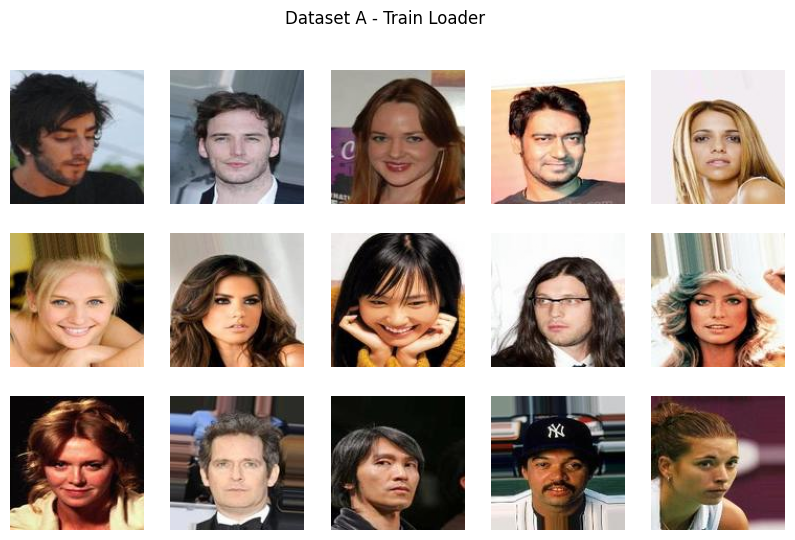

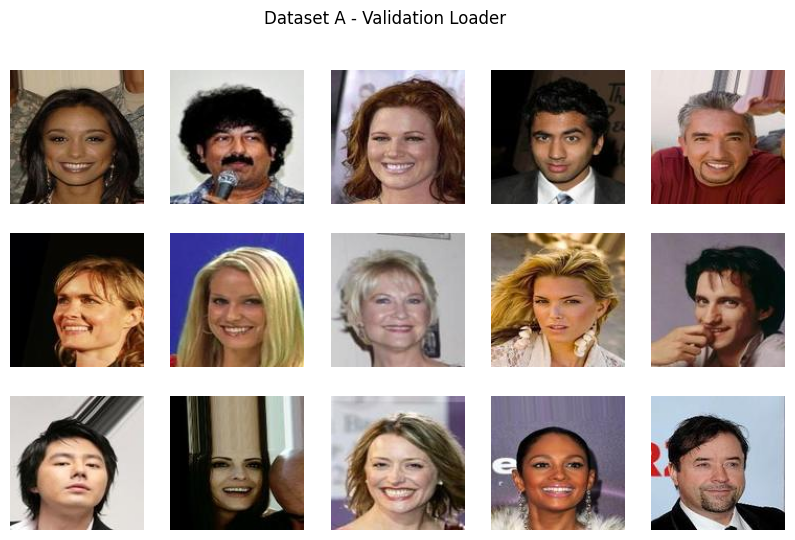

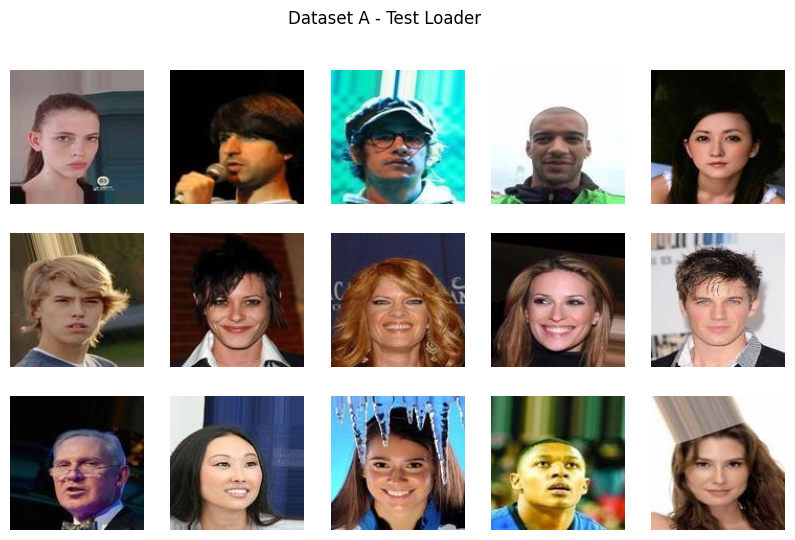

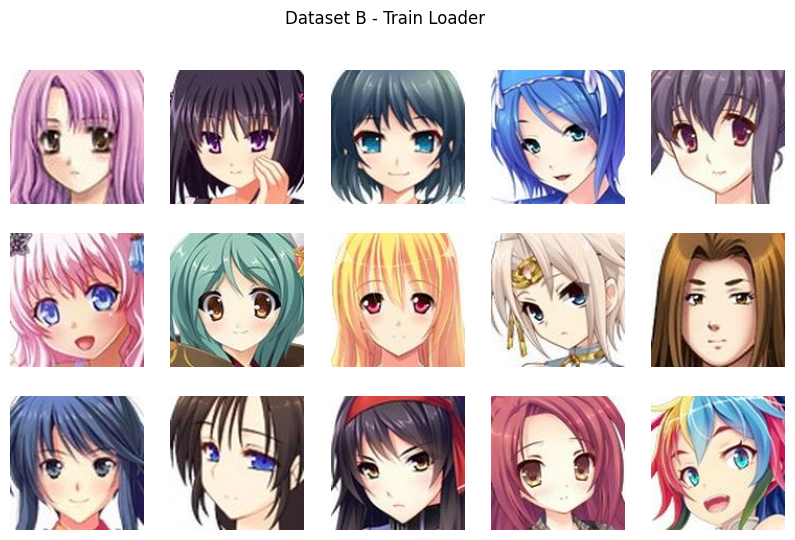

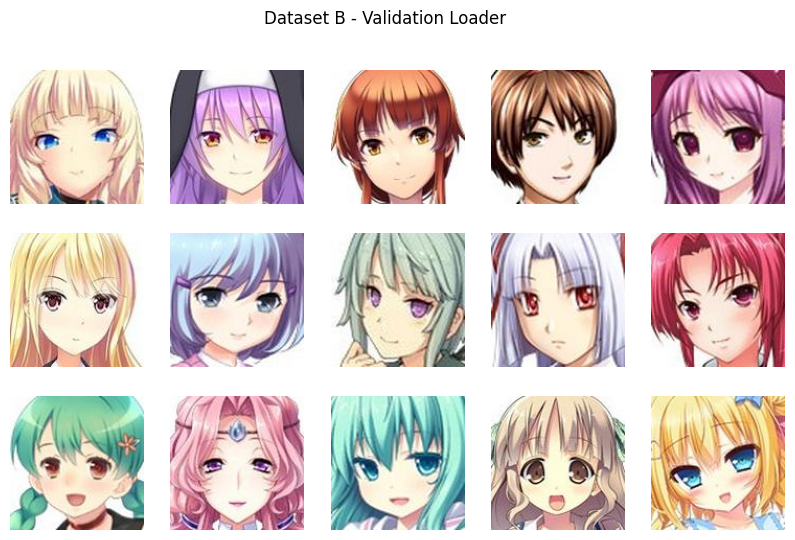

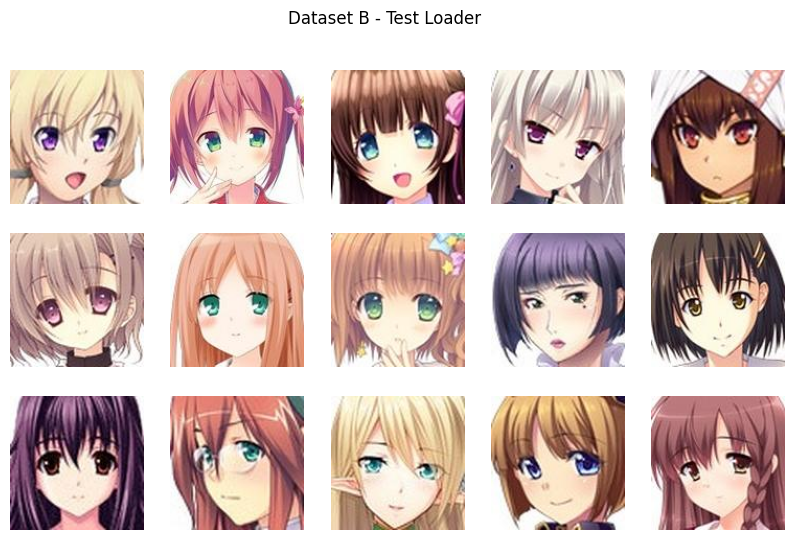

In [35]:
import matplotlib.pyplot as plt

# Taken from Lab 2
def visualize_data_loader(data_loader, title, num_images=15):
    k = 0
    plt.figure(figsize=(10, 6))
    for images, labels in data_loader:
        for i in range(images.size(0)):  
            if k >= num_images:
                break
            image = images[i]
            img = np.transpose(image.numpy(), [1, 2, 0])
            img = img / 2 + 0.5
            plt.subplot(3, 5, k+1)
            plt.axis('off')
            plt.imshow(img)
            k += 1
        if k >= num_images:
            break
    plt.suptitle(title)
    plt.show()

# Visualize dataset A
visualize_data_loader(train_loader_A, title="Dataset A - Train Loader")
visualize_data_loader(val_loader_A, title="Dataset A - Validation Loader")
visualize_data_loader(test_loader_A, title="Dataset A - Test Loader")

# Visualize dataset B
visualize_data_loader(train_loader_B, title="Dataset B - Train Loader")
visualize_data_loader(val_loader_B, title="Dataset B - Validation Loader")
visualize_data_loader(test_loader_B, title="Dataset B - Test Loader")